In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
from matplotlib import pyplot
import math
import SumSinceTrendIndy
#https://medium.com/datawiz-th/%E0%B8%A1%E0%B8%B2%E0%B8%A5%E0%B8%AD%E0%B8%87-forecast-%E0%B8%A3%E0%B8%B2%E0%B8%84%E0%B8%B2%E0%B8%AB%E0%B8%B8%E0%B9%89%E0%B8%99%E0%B9%81%E0%B8%9A%E0%B8%9A%E0%B8%87%E0%B9%88%E0%B8%B2%E0%B8%A2%E0%B9%86-%E0%B8%94%E0%B9%89%E0%B8%A7%E0%B8%A2-deep-learning-lstm-python-305c480db223

In [6]:
ab_path='data/SET50-Daily-Y09-Now.csv'

# way=1;  OK
# Test RMSE: 2.111 
# time_step_predict=66
# predict_ahead=11
# start_date='2016-01-01'
# end_date='2022-12-30'
# ratio_train=0.95

# original
# time_step_predict=66
# predict_ahead=11
# #Test RMSE: 16.922

# # time_step_predict=88
# # predict_ahead=11
# #16.047

# ratio_train=0.75

# prediction_col='Price'
# my_features=['Price','EMA1']


way=1;

isTrendTranform=False

start_date='2016-01-01'
end_date='2022-12-30'

time_step_predict=25
predict_ahead=5

ratio_train=0.9

epochs = 50
batch_size = 32
n_early=0

# Load data typically

In [7]:
# prediction_col='MACD'
# my_features=['MACD','SIGNAL']

prediction_col='SIGNAL'
#my_features=['Price','EMA1','MACD']

my_features=['SIGNAL']


df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':'Date'},inplace=True)
allCols=list(df.columns)
print(allCols)

df['Date']=df['Date'].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index('Date',inplace=True)
df=df.loc[start_date:end_date,my_features]
print(df.info())
df.tail()

['Ticker', 'Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1692 entries, 2016-01-04 to 2022-12-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SIGNAL  1692 non-null   float64
dtypes: float64(1)
memory usage: 26.4 KB
None


,SIGNAL
Date,
2022-12-09,1.83
2022-12-13,1.53
2022-12-14,1.30
2022-12-15,1.05
2022-12-16,0.81


# Convert technincal indicator to trend-feature

In [8]:
# 1.read data from somewhere as this format
# dfIndy=pd.read_csv(f'{ab_path}',index_col='Date/Time',parse_dates=['Date/Time'],dayfirst=True)
# dfIndy=dfIndy[start_date:]
# print(dfIndy.info())

# #2. transform feature and select  trend columns such sum or count
# prediction_col='SIGNAL'
# colToFeature=prediction_col

# my_features=[prediction_col, f'{prediction_col}_Up',f'{prediction_col}_Down']

# df,dfUp,dfDown=SumSinceTrendIndy.create_trend_feature(dfIndy,colToFeature)
# df.set_index('Date',inplace=True)
# df=df[my_features]

# #3. plot show data
# df.plot(kind='line',layout=(len(my_features),1),
#                         sharex=True,subplots=True,figsize=(15, 3*len(my_features)))
# pyplot.show()

# df.tail(3)

In [9]:
num_cols=len(df.columns.tolist())
groups =list(range(0,num_cols))
print(groups)

[0]


# Arima Decomplose



Date
2022-11-18    4.71
2022-11-25    3.65
2022-12-02    2.85
2022-12-09    1.83
2022-12-16    0.81
Freq: W-FRI, Name: SIGNAL, dtype: float64

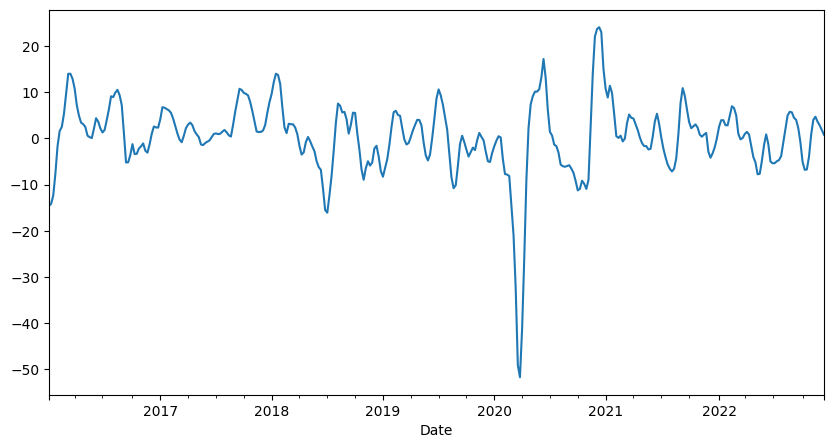

In [10]:
df_x=df[prediction_col].resample('W-FRI').last()
df_x.plot(figsize=(10,5))
df_x.tail()

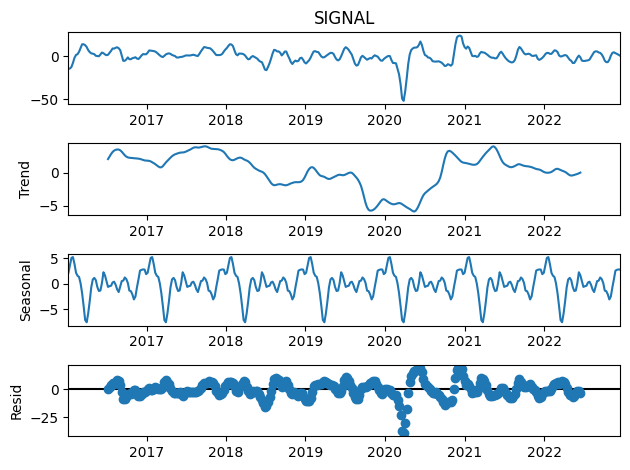

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
#results = seasonal_decompose(df[prediction_col], model='additive') # error
results = seasonal_decompose(df_x, model='additive')
results.plot();

# Get Numpy Values

In [12]:
values = df.values
values = values.astype('float32')
print(values[-5:])
print(values.shape)

[[1.83]
 [1.53]
 [1.3 ]
 [1.05]
 [0.81]]
(1692, 1)


# Feature eng Normalize

In [13]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler ()
scaled_values = scaler.fit_transform(values)
scaled_values=np.around(scaled_values,decimals=5)
print(scaled_values[-5:])
print(scaled_values.shape)

[[0.71008]
 [0.70618]
 [0.70319]
 [0.69995]
 [0.69683]]
(1692, 1)


In [14]:
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:
df_reframed = series_to_supervised(scaled_values, time_step_predict, predict_ahead,feat_name=df.columns)
df_reframed.reset_index(drop=True,inplace=True)
print(df_reframed.shape)
print(df_reframed.info())
df_reframed.tail(1)


(1663, 30)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SIGNAL(t-25)  1663 non-null   float32
 1   SIGNAL(t-24)  1663 non-null   float32
 2   SIGNAL(t-23)  1663 non-null   float32
 3   SIGNAL(t-22)  1663 non-null   float32
 4   SIGNAL(t-21)  1663 non-null   float32
 5   SIGNAL(t-20)  1663 non-null   float32
 6   SIGNAL(t-19)  1663 non-null   float32
 7   SIGNAL(t-18)  1663 non-null   float32
 8   SIGNAL(t-17)  1663 non-null   float32
 9   SIGNAL(t-16)  1663 non-null   float32
 10  SIGNAL(t-15)  1663 non-null   float32
 11  SIGNAL(t-14)  1663 non-null   float32
 12  SIGNAL(t-13)  1663 non-null   float32
 13  SIGNAL(t-12)  1663 non-null   float32
 14  SIGNAL(t-11)  1663 non-null   float32
 15  SIGNAL(t-10)  1663 non-null   float32
 16  SIGNAL(t-9)   1663 non-null   float32
 17  SIGNAL(t-8)   1663 non-null   float32
 18  SIGNAL(t-7)   166

,SIGNAL(t-25),SIGNAL(t-24),SIGNAL(t-23),SIGNAL(t-22),SIGNAL(t-21),SIGNAL(t-20),SIGNAL(t-19),SIGNAL(t-18),SIGNAL(t-17),SIGNAL(t-16),...,SIGNAL(t-5),SIGNAL(t-4),SIGNAL(t-3),SIGNAL(t-2),SIGNAL(t-1),SIGNAL(t),SIGNAL(t+1),SIGNAL(t+2),SIGNAL(t+3),SIGNAL(t+4)
1662,0.68437,0.69631,0.70657,0.71657,0.72488,0.73137,0.73838,0.7437,0.74786,0.74968,...,0.72436,0.72332,0.72137,0.71825,0.71436,0.71008,0.70618,0.70319,0.69995,0.69683


In [16]:
# remove unused predicted column
# list column as predicted value
listTargetCol=[f'{prediction_col}(t)'] 
listTargetCol2=  [ f'{prediction_col}(t+{n})' for n in  range(1,(predict_ahead))]
listTargetCol.extend(listTargetCol2)
print(f"These cols are used to predict :{listTargetCol}")

# drop columns since var2(t), keep only var1(t)  as predict value
reframe_cols=list(df_reframed.columns)
# reframe_cols=sorted(reframe_cols)
# print(f"Print all column in df reframed prior to removal")
# print(reframe_cols)
listAllDelete=[]
for colName in list(df.columns):
   if colName != prediction_col: 
    colsToDel=[ c for c in reframe_cols  if (c.startswith(f"{colName}(t+")) or (c==f"{colName}(t)") ] 
    listAllDelete.extend(colsToDel)
print(f"These columns will be excluded :{listAllDelete} to predict")



df_reframed=df_reframed.drop(columns=listAllDelete, axis=1)
print(df_reframed.info())

print(df_reframed.shape)


print(df_reframed.head(time_step_predict))

These cols are used to predict :['SIGNAL(t)', 'SIGNAL(t+1)', 'SIGNAL(t+2)', 'SIGNAL(t+3)', 'SIGNAL(t+4)']
These columns will be excluded :[] to predict
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SIGNAL(t-25)  1663 non-null   float32
 1   SIGNAL(t-24)  1663 non-null   float32
 2   SIGNAL(t-23)  1663 non-null   float32
 3   SIGNAL(t-22)  1663 non-null   float32
 4   SIGNAL(t-21)  1663 non-null   float32
 5   SIGNAL(t-20)  1663 non-null   float32
 6   SIGNAL(t-19)  1663 non-null   float32
 7   SIGNAL(t-18)  1663 non-null   float32
 8   SIGNAL(t-17)  1663 non-null   float32
 9   SIGNAL(t-16)  1663 non-null   float32
 10  SIGNAL(t-15)  1663 non-null   float32
 11  SIGNAL(t-14)  1663 non-null   float32
 12  SIGNAL(t-13)  1663 non-null   float32
 13  SIGNAL(t-12)  1663 non-null   float32
 14  SIGNAL(t-11)  1663 non-null   float32
 15  SIGNA

# Split Data and Reshape to be well-suited

In [17]:
# split into train and test sets

values = df_reframed.values
n_train=math.ceil(len(df_reframed) * ratio_train)
print(f' no train is {ratio_train*100} % of {len(values)}= {n_train}')

train = values[:n_train, :]
test = values[n_train:, :]
print(train.shape)
print(test.shape)


 no train is 90.0 % of 1663= 1497
(1497, 30)
(166, 30)


In [18]:
# keep date data
date_reframed = df.index[df_reframed.index]
date_train = date_reframed[:n_train]
date_test = date_reframed[n_train:]
print(f"All Data : {date_reframed.min()} - {date_reframed.max()}")
print(f"Train Data : {date_train.min()} - {date_train.max()}")
print(f"Test Data : {date_test.min()} - {date_test.max()}")

All Data : 2016-01-04 00:00:00 - 2022-11-03 00:00:00
Train Data : 2016-01-04 00:00:00 - 2022-02-23 00:00:00
Test Data : 2022-02-24 00:00:00 - 2022-11-03 00:00:00


In [19]:
# split feature และ target
train_X, train_y = train[:, :-predict_ahead], train[:, -predict_ahead:]
test_X, test_y = test[:, :-predict_ahead], test[:, -predict_ahead:]

print(f"Train X y = {train_X.shape} , {train_y.shape}")
print(f"Test X y = {test_X.shape} , {test_y.shape}")

Train X y = (1497, 25) , (1497, 5)
Test X y = (166, 25) , (166, 5)


In [20]:
# reshape input X to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0],1 , train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(f"Reshape Train X to LSTM  = {train_X.shape} , {train_y.shape}")
print(f"Reshape Test X  to LSTM = {test_X.shape} , {test_y.shape}")

Reshape Train X to LSTM  = (1497, 1, 25) , (1497, 5)
Reshape Test X  to LSTM = (166, 1, 25) , (166, 5)


In [21]:
print("=======Apply These features=============")
# print([ col for col in list(df_reframed.columns) if col not in listTargetCol ])
print(train_X[:2])
print("===========To Predict===================")
# print ( listTargetCol )
print(train_y[:2])

=======Apply These features=============
[[[0.50727 0.50662 0.50571 0.50117 0.49701 0.49273 0.49117 0.49442
   0.49909 0.50247 0.50519 0.51013 0.5148  0.51922 0.52623 0.53506
   0.54505 0.55674 0.57076 0.58764 0.60517 0.62101 0.63581 0.65009
   0.6645 ]]

 [[0.50662 0.50571 0.50117 0.49701 0.49273 0.49117 0.49442 0.49909
   0.50247 0.50519 0.51013 0.5148  0.51922 0.52623 0.53506 0.54505
   0.55674 0.57076 0.58764 0.60517 0.62101 0.63581 0.65009 0.6645
   0.67775]]]
===========To Predict===================
[[0.67775 0.6893  0.69904 0.70488 0.70774]
 [0.6893  0.69904 0.70488 0.70774 0.70969]]


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Flatten,Dropout


In [23]:

inputshape_Timestamps= train_X.shape[1]
no_feature=train_X.shape[2]

n_neurons = inputshape_Timestamps *no_feature
#n_neurons=50

n_output_neurons = predict_ahead

print(f"{n_neurons} = {inputshape_Timestamps} x {no_feature} to predict {n_output_neurons}")

25 = 1 x 25 to predict 5


In [24]:
np.random.seed(7)

model=Sequential()

# Way1
if way==1:
 print("One Layer")   
 model.add(LSTM(units=n_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))


# Way2
elif way==2:
    print("Two Layer") 
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(inputshape_Timestamps,no_feature))) 
    model.add(LSTM(n_neurons, return_sequences=False))


# Way3 return_sequences for adding other hidden layer
else:
    print("One Layer and Dropout 20%") 
    model.add( LSTM (units=n_neurons, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2] )))                                                                                            
    model.add(Dropout(0.2))
    model.add(LSTM(units=n_neurons)) #layer2  additonal
    model.add(Dropout(0.2))



model.add(Dense(n_output_neurons))
                                                                                    
                                                                                             
model.compile(loss='mean_squared_error', optimizer='adam')

One Layer


In [25]:
callback = EarlyStopping(monitor='loss', patience=n_early)

t_Start=time.time()
print(datetime.now())

if n_early==0:
    print("Train")

    history = model.fit(train_X, train_y, epochs=epochs,shuffle=False, batch_size=batch_size, validation_data=(test_X, test_y), \
                        verbose=2)
else:
    print("Train with no early stop")
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), \
                        verbose=2, shuffle=False,callbacks=[callback])



t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execute making report : ',round(t_elapsed,2)) 
print(datetime.now())

2022-12-27 22:38:18.051294
Train
Epoch 1/50
47/47 - 5s - loss: 0.1126 - val_loss: 0.0044 - 5s/epoch - 107ms/step
Epoch 2/50
47/47 - 0s - loss: 0.0093 - val_loss: 0.0031 - 244ms/epoch - 5ms/step
Epoch 3/50
47/47 - 0s - loss: 0.0084 - val_loss: 0.0030 - 390ms/epoch - 8ms/step
Epoch 4/50
47/47 - 0s - loss: 0.0080 - val_loss: 0.0028 - 335ms/epoch - 7ms/step
Epoch 5/50
47/47 - 0s - loss: 0.0075 - val_loss: 0.0027 - 311ms/epoch - 7ms/step
Epoch 6/50
47/47 - 0s - loss: 0.0070 - val_loss: 0.0025 - 331ms/epoch - 7ms/step
Epoch 7/50
47/47 - 0s - loss: 0.0066 - val_loss: 0.0024 - 302ms/epoch - 6ms/step
Epoch 8/50
47/47 - 0s - loss: 0.0061 - val_loss: 0.0023 - 294ms/epoch - 6ms/step
Epoch 9/50
47/47 - 0s - loss: 0.0057 - val_loss: 0.0022 - 296ms/epoch - 6ms/step
Epoch 10/50
47/47 - 0s - loss: 0.0053 - val_loss: 0.0021 - 251ms/epoch - 5ms/step
Epoch 11/50
47/47 - 0s - loss: 0.0049 - val_loss: 0.0021 - 240ms/epoch - 5ms/step
Epoch 12/50
47/47 - 0s - loss: 0.0045 - val_loss: 0.0020 - 257ms/epoch - 5m

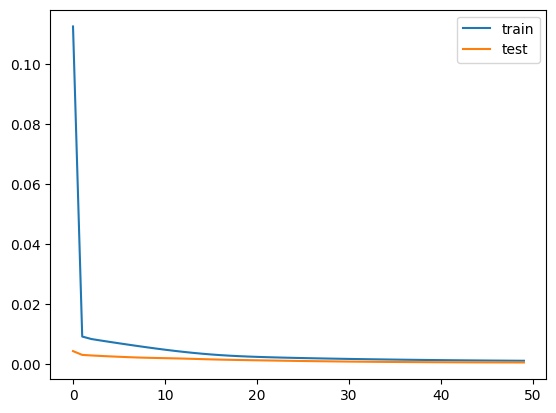

In [26]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25)                5100      
                                                                 
 dense (Dense)               (None, 5)                 130       
                                                                 
Total params: 5,230
Trainable params: 5,230
Non-trainable params: 0
_________________________________________________________________


In [28]:
# import shap

# # train_shapML=train_X.reshape((train_X.shape[0], train_X.shape[2]))
# # test_shapeML = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # print(train_shapML.shape,test_shapeML.shape)

# # Use the training data for deep explainer => can use fewer instances
# explainer_ = shap.DeepExplainer(model, (train_X))
# shap_values_ = explainer_.shap_values(test_X)

In [29]:
yhat = model.predict(test_X)
print("========= yhat Predict Value==============")
print(yhat[:2])
print(yhat.shape)

print("========== test_X Features to predict===========")
print(test_X.shape)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X.shape)
print(test_X[:2])


6/6 [==============================] - 1s 3ms/step
========= yhat Predict Value==============
[[0.67435277 0.6810683  0.6843811  0.68351406 0.6939625 ]
 [0.6799923  0.68676937 0.6905716  0.6899992  0.69951004]]
(166, 5)
========== test_X Features to predict===========
(166, 1, 25)
(166, 25)
[[0.77681 0.77175 0.76668 0.76227 0.75863 0.75578 0.75136 0.74202 0.72994
  0.71825 0.70774 0.6993  0.6932  0.68735 0.68398 0.68333 0.68385 0.6845
  0.68554 0.68619 0.68709 0.68761 0.68826 0.68982 0.69242]
 [0.77175 0.76668 0.76227 0.75863 0.75578 0.75136 0.74202 0.72994 0.71825
  0.70774 0.6993  0.6932  0.68735 0.68398 0.68333 0.68385 0.6845  0.68554
  0.68619 0.68709 0.68761 0.68826 0.68982 0.69242 0.6954 ]]


# Concat Target and Feature and InverseTRansform

In [30]:
# invest predict data Y
inv_yhat = yhat*( scaler.data_max_[0] - scaler.data_min_[0] )+scaler.data_min_[0]
print(inv_yhat.shape)
inv_yhat[:2]

(166, 5)


array([[-0.9213486 , -0.40411758, -0.14896393, -0.21574402,  0.5889969 ],
       [-0.48698807,  0.03498077,  0.32782745,  0.283741  ,  1.0162659 ]],
      dtype=float32)

In [31]:
#invest actual data Y
inv_y = test_y*( scaler.data_max_[0] - scaler.data_min_[0] )+scaler.data_min_[0]
print(inv_y.shape)
inv_y[:2]

(166, 5)


array([[0.69971085, 0.9700508 , 1.2303772 , 1.4699097 , 1.5199699 ],
       [0.9700508 , 1.2303772 , 1.4699097 , 1.5199699 , 1.4298592 ]],
      dtype=float32)

In [32]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.925


# Plot Multiple Forcast (Most Complex Step)

In [33]:
import numpy as np
# also show the price of previous 30 days + datetime
idx = np.random.randint(0,len(yhat)-predict_ahead)
print(idx)

25


In [34]:
print(f"Test Data : {date_test.min()} - {date_test.max()}")
(date_test.max()-date_test.min())

Test Data : 2022-02-24 00:00:00 - 2022-11-03 00:00:00


Timedelta('252 days 00:00:00')

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_8004\4102265979.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


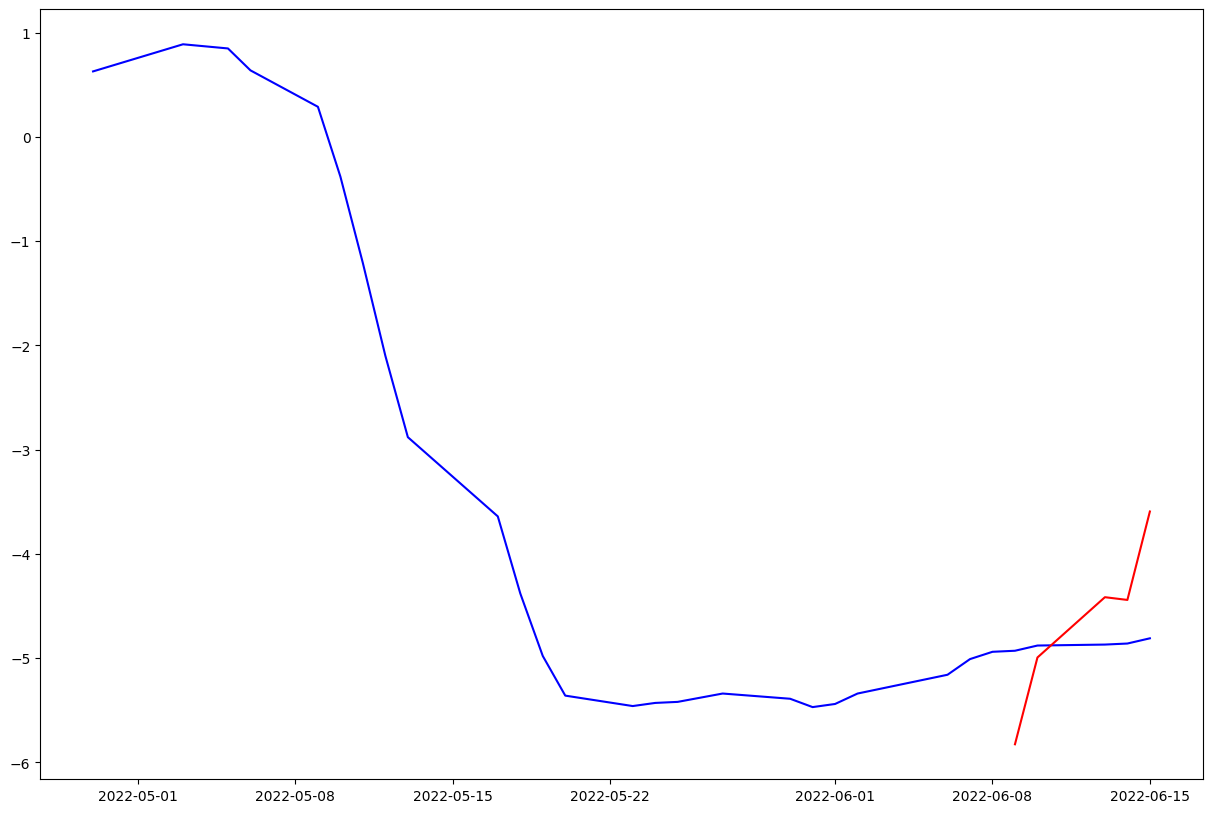

In [35]:
import numpy as np
idx = np.random.randint(0,len(yhat-predict_ahead))
if idx < time_step_predict:
  date_actual = date_test[:idx+predict_ahead]
else:
  date_actual = date_test[idx-time_step_predict:idx+predict_ahead]
fig=pyplot.figure(figsize=(15,10))
_=pyplot.plot(date_actual,inv_y[max(0,idx-time_step_predict):idx+predict_ahead,0],'b')
_=pyplot.plot(date_test[idx:idx+predict_ahead],inv_yhat[idx],'r')
fig.show()